### Проект для «Викишоп». Машинное обучение для текстов

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.


- Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
- Постройте модель со значением метрики качества F1 не меньше 0.75.

### Импорт библиотек

In [1]:
!pip install nltk

In [2]:
!pip install pymystem3

In [3]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords as stopwords

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
import re

from numpy.random import RandomState
rdm = RandomState(1234)

import matplotlib.pyplot as plt
import seaborn as sns

### Чтение и анализ датасета

In [4]:
data = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№12 Тексты/toxic_comments (1).csv')

In [5]:
data.sample(5)

,Unnamed: 0,text,toxic
71272,71342,"""\nPro Moldovan?? What in hell!!! do I have to...",1
144433,144589,What the fuck is your problem?,1
105603,105700,"Birmingham \n\nHi, I noticed your comment at t...",0
46889,46944,"There is Postini, Message Labs, Microsoft Exch...",0
22174,22194,""":Ah, well if we're mentioning television show...",0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

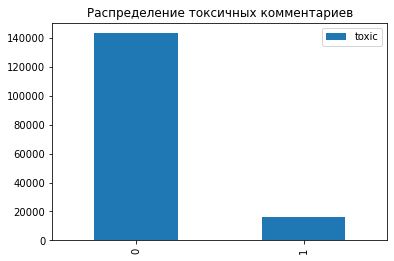

In [8]:
data['toxic'].value_counts().plot(kind='bar', label='toxic')
plt.legend()
plt.title('Распределение токсичных комментариев');

## Предобработка данных

### Приведение  к нижнему регистру

### Удаление лишних пробелов и работа с регулярными выражениями (удаление ненужных для анализа символов)

In [9]:
print("Исходный текст:", data['text'].head())

Исходный текст: 0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object


In [10]:
m = Mystem()

def clear_text(text):    
    text = text.lower()
    c_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return " ".join(c_text.split())
data['text'] = data['text'].apply(clear_text)

In [11]:
print("Чистый текст:", data['text'].head())

Чистый текст: 0    explanation why the edits made under my userna...
1    d aww he matches this background colour i m se...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestions on impr...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object


### Лемматизация spaCy 

In [12]:
# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.5 MB/s eta 0:00:0000:0100:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def text_lemmatizer(text):
    doc = nlp(text)
    return ' '.join([word.lemma_ for word in doc])

In [14]:
data['text'] = data['text'].apply(text_lemmatizer)

In [15]:
print("Лемматизированный текст:", data['text'].head())

Лемматизированный текст: 0    explanation why the edit make under my usernam...
1    d aww he match this background colour I m seem...
2    hey man I m really not try to edit war it s ju...
3    more I can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object


### Исправление ошибок

In [16]:
#!pip install pyspellchecker

In [17]:
#from spellchecker import SpellChecker

#def spell_check(text):
    
    #result = []
    #spell = SpellChecker()
    #for word in text:
        #correct_word = spell.correction(word)
        #result.append(correct_word)
    
    #return ' '.join(spell_check(data['text']))



In [18]:
#data['text'] = data['text'].apply(spell_check)

### Удаление стоп-слов, TF-IDF

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/l.stefanenko/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
stopwords = set(stopwords.words("english"))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

### Разделение на выборки

In [21]:
features = data.drop(['toxic'], axis=1)

In [22]:
target = data['toxic']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(features,target,test_size=0.4, random_state=rdm)

In [24]:
x_train = count_tf_idf.fit_transform(x_train['text'])
x_test = count_tf_idf.transform(x_test['text'])

## Построение моделей для машинного обучения

### Дерево решений

In [25]:
%%time
model = DecisionTreeClassifier()
model.fit(x_train,y_train)

predictions = model.predict(x_test)

F1_DT = f1_score(y_test, predictions)
print ("F1_score DecisionTreeClassifier:",F1_DT)

F1_score DecisionTreeClassifier: 0.7165525824517734
CPU times: user 4min 16s, sys: 572 ms, total: 4min 17s
Wall time: 4min 19s


### Дерево решений с использоваием GridSearchCV

In [26]:
%%time
model = DecisionTreeClassifier(random_state = rdm)
params = {
   'criterion':['gini', 'entropy'],        
   'max_depth':list(range(1,15,5)) 
}
tree_gs = GridSearchCV(model, params, cv=3, scoring='f1', verbose=False).fit(x_train, y_train)
target_predictions = tree_gs.predict(x_test) 
F1_score_DT_with_GS = tree_gs.best_score_
print (F1_score_DT_with_GS)

0.6084113344150545
CPU times: user 2min 34s, sys: 956 ms, total: 2min 34s
Wall time: 2min 36s


### Логистическая регрессия

In [27]:
%%time
model = LogisticRegression (random_state = rdm, class_weight = 'balanced')
params = {
    'penalty': ['l1','l2'],
    'C':[0.5,1.0,5.0,15.0],
    'intercept_scaling':range(5,100,40),
    'solver':['liblinear']
}
tree_gs = GridSearchCV(model, params, cv=3, scoring='f1', verbose=False).fit(x_train, y_train)

F1_score_LR = tree_gs.best_score_
print(F1_score_LR)
print(tree_gs.best_params_)

0.7623236065291453
{'C': 5.0, 'intercept_scaling': 5, 'penalty': 'l2', 'solver': 'liblinear'}
CPU times: user 3min 17s, sys: 3.16 s, total: 3min 21s
Wall time: 2min 25s


## Результаты

In [28]:
df_train_result = pd.DataFrame(
   
    index=['дерево_решений',
           'дерево_решений_GS',
           'логистическая_регрессия']
)
df_train_result['|'] =  '|'

In [29]:
df_train_result.loc['дерево_решений','F1_score'] = F1_DT
df_train_result.loc['дерево_решений_GS','F1_score'] = F1_score_DT_with_GS
df_train_result.loc['логистическая_регрессия','F1_score'] = F1_score_LR

In [30]:
display(df_train_result)

,|,F1_score
дерево_решений,|,0.716553
дерево_решений_GS,|,0.608411
логистическая_регрессия,|,0.762324


### Вывод о работе лучше модели

Наилучшие результаты показала модель логистической регрессии со следующими параметрами:  
- 'penalty': ['l2'],
- 'C':[0.15],
- 'intercept_scaling':range(5),
- 'solver':['liblinear']

F1_score  на этой модели равен 0.762324

### Эффективность работы полученной модели

In [92]:
f1_score_fin = f1_score(y_test, tree_gs.predict(x_test))
print(f1_score_fin)

0.7686116700201207


In [84]:
result = pd.DataFrame(tree_gs.predict(x_test), columns=['target_predictions'])

In [85]:
display (result.head())

,target_predictions
0,0
1,0
2,0
3,0
4,0


In [37]:
#result.to_csv('predictions')

In [86]:
result.value_counts()

target_predictions
0                     56232
1                      7485
dtype: int64

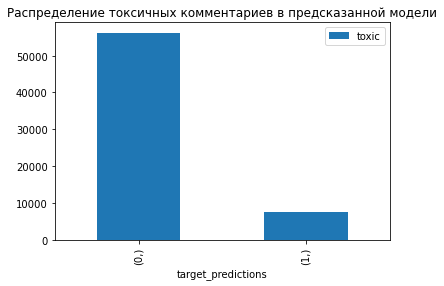

In [87]:
result.value_counts().plot(kind='bar', label='toxic')
plt.legend()
plt.title('Распределение токсичных комментариев в предсказанной модели');

In [88]:
from sklearn.metrics import confusion_matrix

In [90]:
y_test.head()

74919     0
112284    0
13185     0
54358     0
152791    0
Name: toxic, dtype: int64

In [91]:
cm = confusion_matrix(y_test, target_predictions)
display (cm)

array([[55149,  2137],
       [ 1083,  5348]])

### Общий вывод

Лучшей моделью оказалась линейная регрессия. 
Матрица confusion_matrix показывает, что результаты модели на тестовой выборке дают хорошие показатели: 

55149 положительных предсказаний, когда они действительно были правдой
5348 отрицательных предсказаний, когда они были toxic

ошибки первого и второго рода в матрице равны 2137 и 1083 соответвенно. Это около одного процента от предсказаний.
Наилучшие результаты показала модель логистической регрессии со следующими параметрами:  
- 'penalty': ['l2'],
- 'C':[0.15],
- 'intercept_scaling':range(5),
- 'solver':['liblinear']

    f1 на тестовой выборке равен 0.7686